<a href="https://colab.research.google.com/github/anoukzwinkels/TM10007/blob/master/Ideal_amount_of_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/anoukzwinkels/TM10007

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection    import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection    import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.feature_selection  import VarianceThreshold, RFECV, SelectKBest, f_classif
from sklearn.metrics            import accuracy_score
from sklearn.metrics            import roc_auc_score
from sklearn.preprocessing      import RobustScaler
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.svm                import SVC
from sklearn.decomposition      import PCA

from plotly.express             import scatter_3d, bar
from sklearn.ensemble           import RandomForestClassifier

In [ ]:
def def_data():
  '''
  Load the data
  
  :return features:     dataframe containing the features
  :return labels:       dataframe containing the labels
  '''

  from hn.load_data import load_data
  data = load_data()

  features = data.drop(columns=['label'])       # dit is alle data (input)
  labels = pd.DataFrame(data['label'])          # dit zijn alle labels

  return features, labels

In [ ]:
def remove_outliers(X_train):
  '''
  Identify the outliers and replace them with the minimum or maximum value from the corresponding feature.

  :param X_train:      dataframe containing the features
  :return X_train:     dataframe containing the features with the outliers corrected
  '''

  X_train = X_train.copy()
  
  # calculate interquartile range
  q25, q75 = np.percentile(X_train, 25,axis=0), np.percentile(X_train, 75,axis=0)
  iqr = q75 - q25

  # calculate the outlier cutoff
  cut_off = iqr * 1.5
  lower, upper = q25 - cut_off, q75 + cut_off

  # identify outliers
  outliers = (X_train < lower) | (X_train > upper)
  #outliers = [x for x in features if x < lower or x > upper]

  feature_nan = X_train[:].copy()
  feature_nan[outliers] = np.nan

  feature_names = list(X_train.columns)
  for col in feature_names:
    outliers_col = outliers[col]
    for val in X_train.loc[outliers_col,col]:
      if val > np.nanmax(feature_nan[col]):
        X_train[col] = X_train[col].replace(to_replace = val, value = np.nanmax(feature_nan[col]))
      elif val < np.nanmin(feature_nan[col]):
        X_train[col] = X_train[col].replace(to_replace = val, value = np.nanmin(feature_nan[col]))
  return (X_train)

In [ ]:
def remove_zero_variance(X_train, X_test):
  '''
  Remove the features with zero variance

  :param X_train:             
  :param X_test:              
  :return X_train:
  :return X_test:
  '''

  m = VarianceThreshold(threshold=0.0)
  m.fit(X_train)
  names_chosen_features = m.get_support(indices = True)
  X_train = X_train.iloc[:,names_chosen_features]

  X_test = X_test.iloc[:,names_chosen_features]

  return X_train, X_test

In [ ]:
def scaling(X_train, X_test):
  '''
  To scale the test and train data

  :param X_train:             
  :param X_test:              
  :return X_train:
  :return X_test:
  '''
  
  scaler = RobustScaler()
  scaler.fit(X_train)
  X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
  X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
  return X_train, X_test

In [ ]:
def ideal_features(y_train, X_train, repeat = 5):
  '''
  Creates a 

  :param X_train:             
  :param X_test:  
  :param repeat:     
  '''
   
  scores = []
  times = 0
  Y=np.ravel(y_train)

  while not (times == repeat):
    times += 1
    rfecv = RFECV(
        estimator=RandomForestClassifier(n_estimators=10), step=1,
        cv=RepeatedStratifiedKFold(n_splits=10),
        scoring='roc_auc')
    rfecv.fit(X_train, Y)
    scores.append(rfecv.grid_scores_)

  mean_scores = np.mean(scores, axis=0)

  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (nb of correct classifications)")
  plt.plot(range(1, len(mean_scores) + 1), mean_scores)
  plt.show()
  return

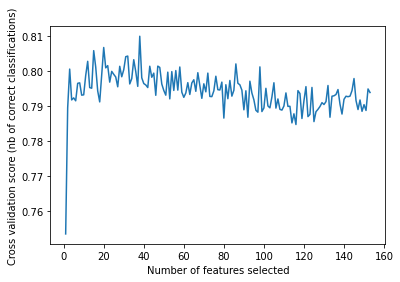

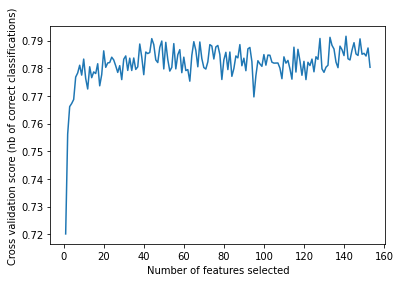

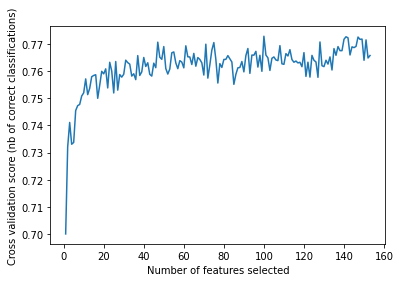

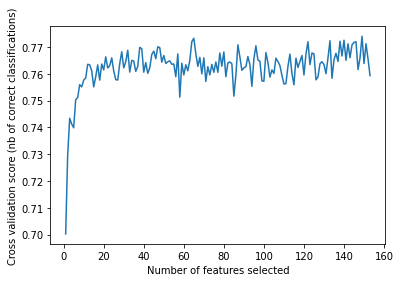

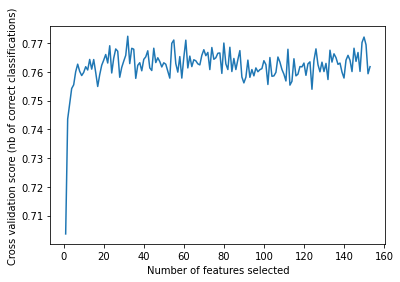

In [ ]:
# This is runned a few times to determine the ideal amount of features
features, labels = def_data()

loops = 0
sss = StratifiedShuffleSplit(n_splits=10)
for train_index, test_index in sss.split(features, labels):
  if loops == 5:
    break
  else:
    loops += 1
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]

    y_train = np.ravel(y_train)
    X_train = remove_outliers(X_train)
    X_train, X_test = scaling(X_train, X_test)
    X_train, X_test = remove_zero_variance(X_train, X_test)
    ideal_features(y_train, X_train)